In [60]:
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 10.2 MB/s eta 0:00:00


In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture
import skfuzzy as fuzz

In [102]:
iris = load_iris()
data = pd.DataFrame(iris.data, columns=iris.feature_names)
clusters = [3, 5, 7]

In [103]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


In [104]:
data_scaled_for_pca = StandardScaler().fit_transform(data)
data_pca = PCA(n_components=2).fit_transform(data_scaled_for_pca)

In [105]:
def preprocess_data(method, data):
    if method == 'standard':
        return StandardScaler().fit_transform(data)
    elif method == 'minmax':
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        filtered_data = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]
        return MinMaxScaler().fit_transform(filtered_data)
    elif method == 'normalized':
        log_data = np.log1p(data + 1)
        return Normalizer().fit_transform(log_data)
    else:
        return data.values


In [106]:
results = []

In [107]:
def run_spectral(X, k):
    model = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', random_state=42)
    labels = model.fit_predict(X)
    score = silhouette_score(X, labels)
    return labels, score

In [108]:
def run_gmm(X, k):
    model = GaussianMixture(n_components=k, random_state=42)
    labels = model.fit_predict(X)
    score = silhouette_score(X, labels)
    return labels, score

In [109]:
def run_fcm(X, k):
    cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(X.T, c=k, m=2, error=0.005, maxiter=1000, init=None)
    labels = np.argmax(u, axis=0)
    score = silhouette_score(X, labels)
    return (cntr, u), labels, score

In [110]:
methods = ['standard', 'minmax', 'normalized']
algorithms = ['Spectral Clustering', 'GMM', 'Fuzzy C-Means']

In [111]:
for method in methods:
    X = preprocess_data(method, data)
    for k in clusters:
        # Spectral Clustering
        try:
            labels, score = run_spectral(X, k)
            results.append({'Algorithm': 'Spectral Clustering', 'Preprocessing': method, 'Clusters': k, 'Silhouette Score': score})
        except:
            pass

        # GMM
        try:
            labels, score = run_gmm(X, k)
            results.append({'Algorithm': 'GMM', 'Preprocessing': method, 'Clusters': k, 'Silhouette Score': score})
        except:
            pass

        # Fuzzy C-Means
        try:
            model, labels, score = run_fcm(X, k)
            results.append({'Algorithm': 'Fuzzy C-Means', 'Preprocessing': method, 'Clusters': k, 'Silhouette Score': score})
        except:
            pass


In [112]:
results_df = pd.DataFrame(results)
best_result = results_df.loc[results_df['Silhouette Score'].idxmax()]

In [113]:
print("\nBest Clustering Result:")
print(f"Algorithm: {best_result['Algorithm']}")
print(f"Preprocessing: {best_result['Preprocessing']}")
print(f"Clusters: {best_result['Clusters']}")
print(f"Silhouette Score: {best_result['Silhouette Score']:.4f}")


Best Clustering Result:
Algorithm: GMM
Preprocessing: normalized
Clusters: 3
Silhouette Score: 0.6447


In [114]:
def visualize_clusters(method, algo_name, clustering_func, data_pca, original_data):
    X = preprocess_data(method, original_data)
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for i, k in enumerate(clusters):
        try:
            if algo_name == 'Fuzzy C-Means':
                model, labels, _ = run_fcm(X, k)
            else:
                labels, _ = clustering_func(X, k)
            sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=labels, palette='viridis', ax=axes[i], alpha=0.8)
            axes[i].set_title(f'{algo_name} ({method})\nClusters: {k}')
        except:
            axes[i].set_visible(False)
    plt.tight_layout()
    plt.show()


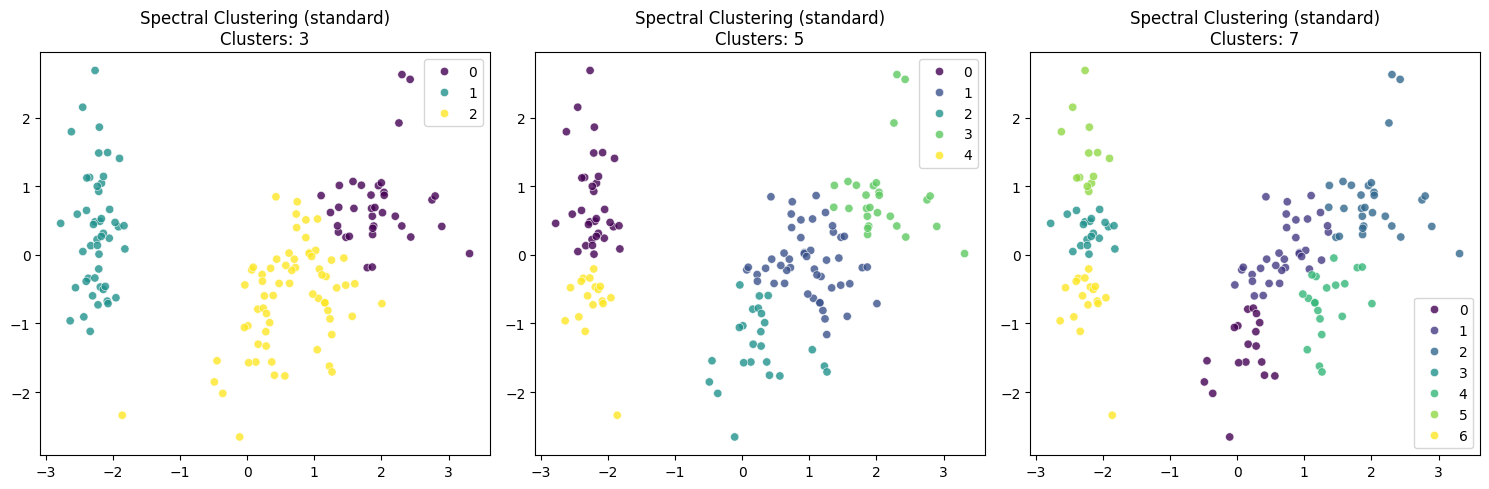

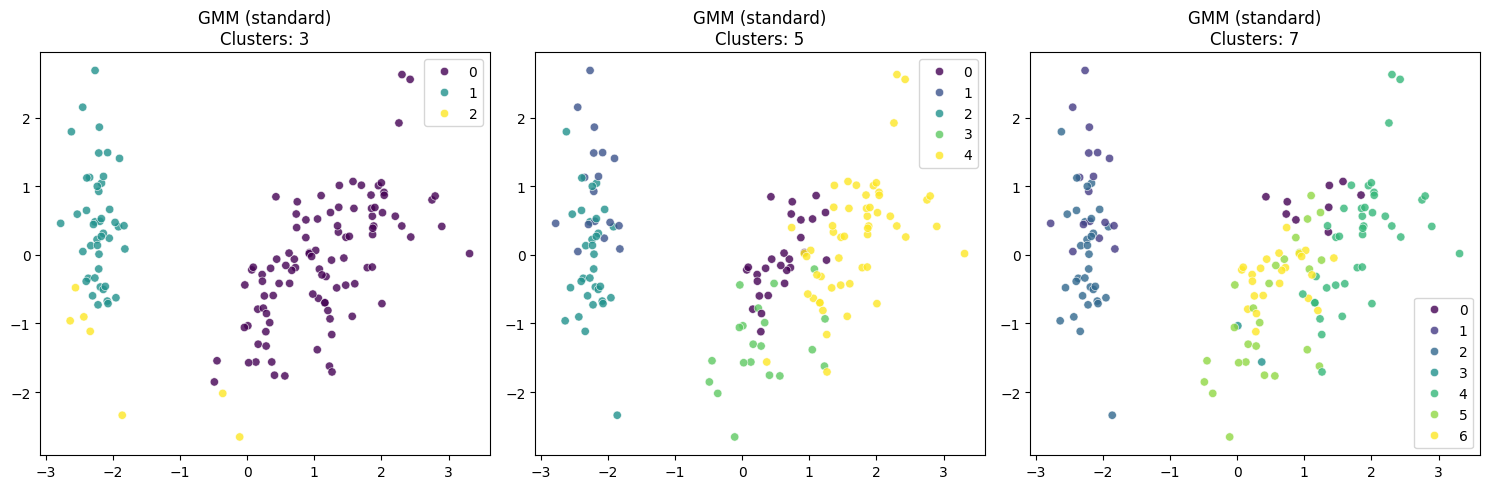

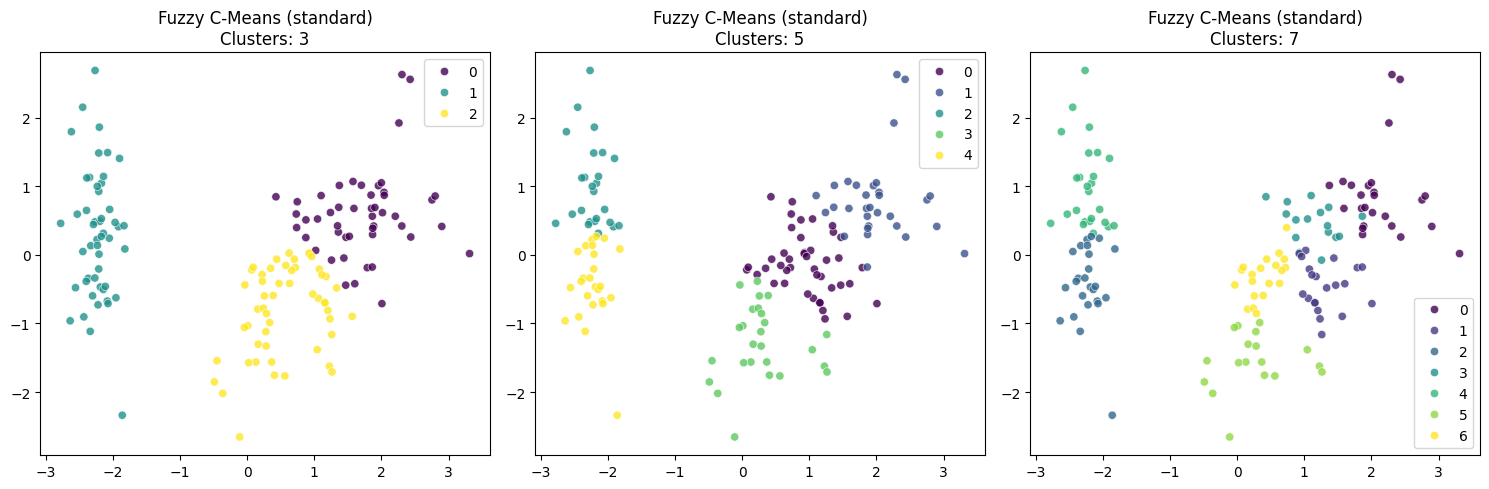

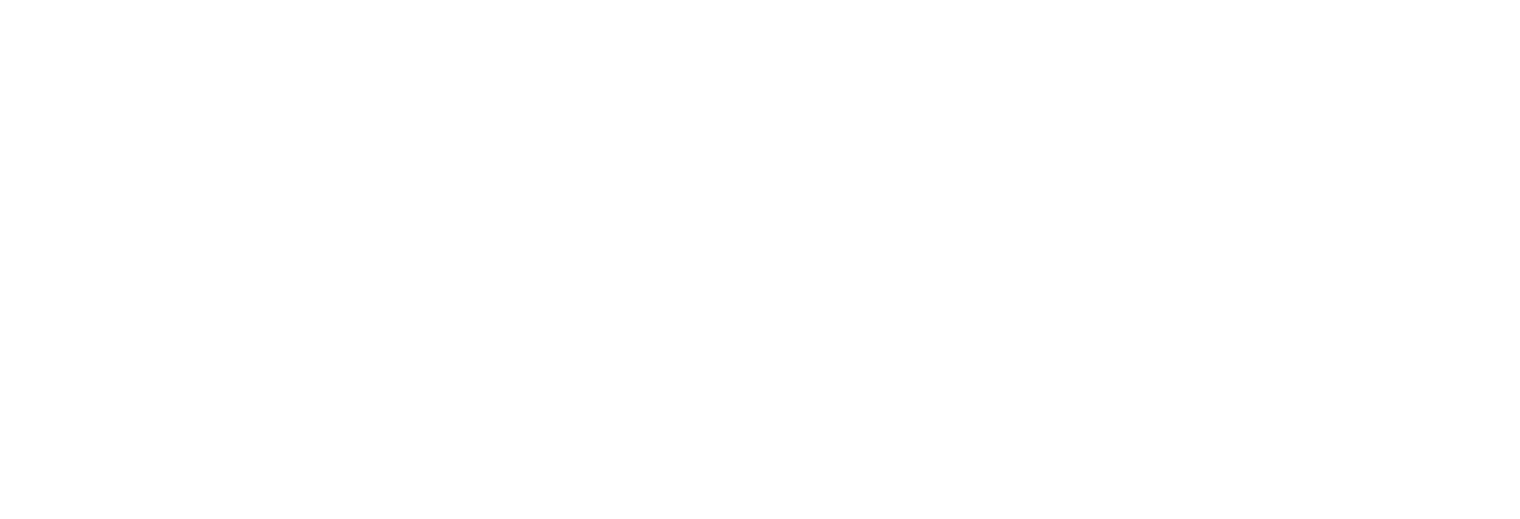

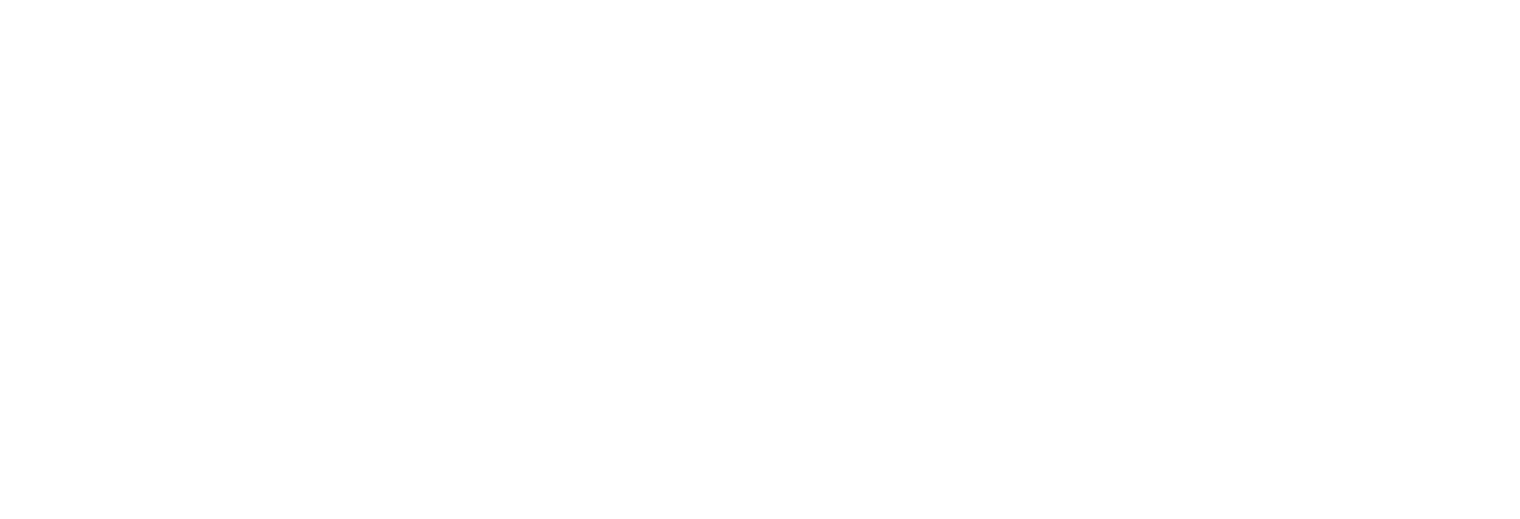

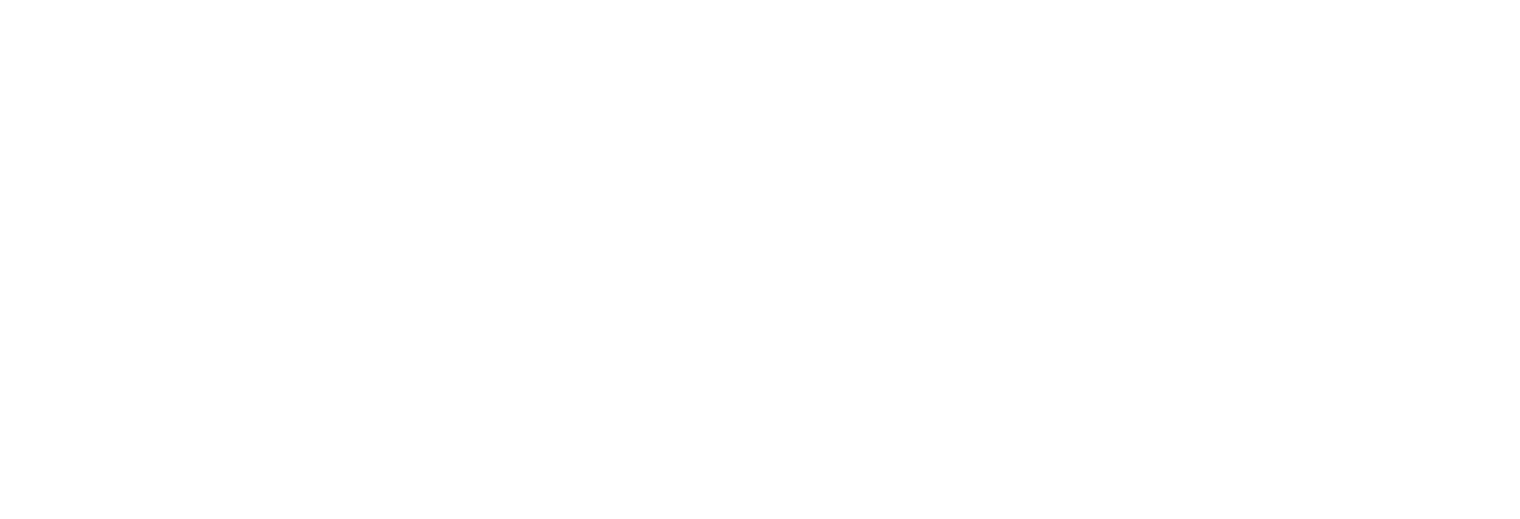

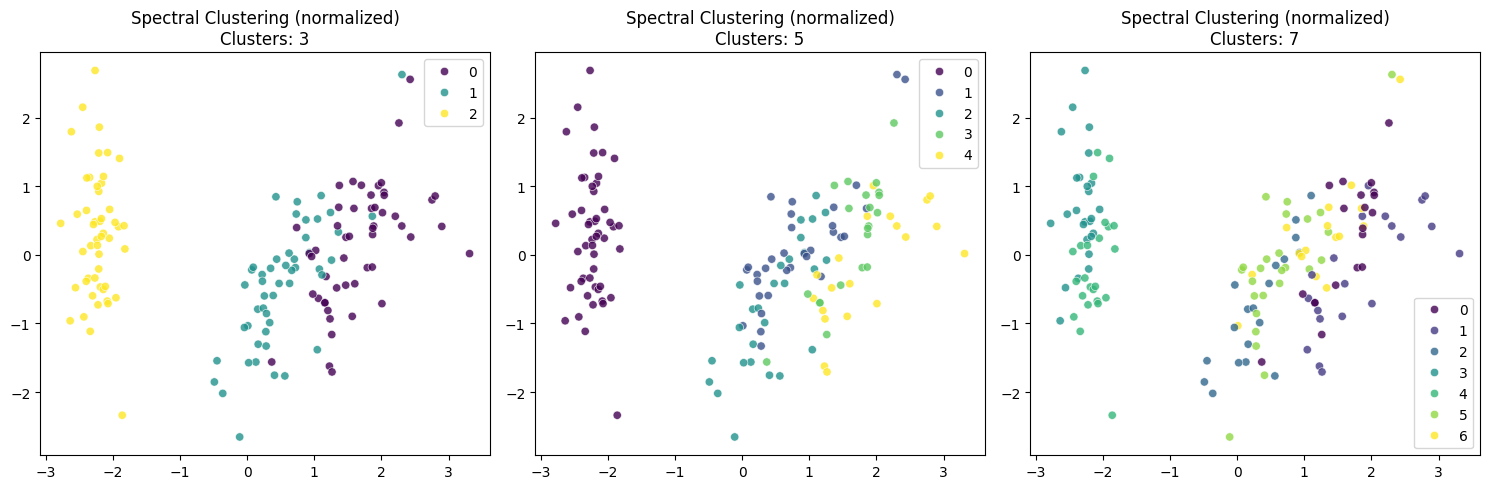

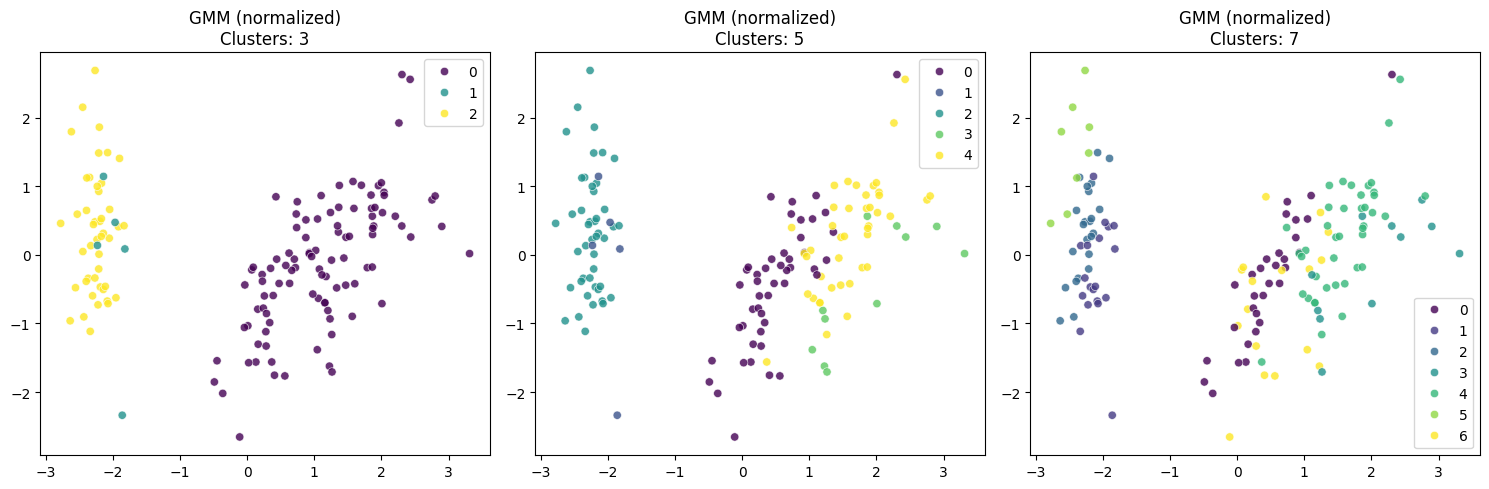

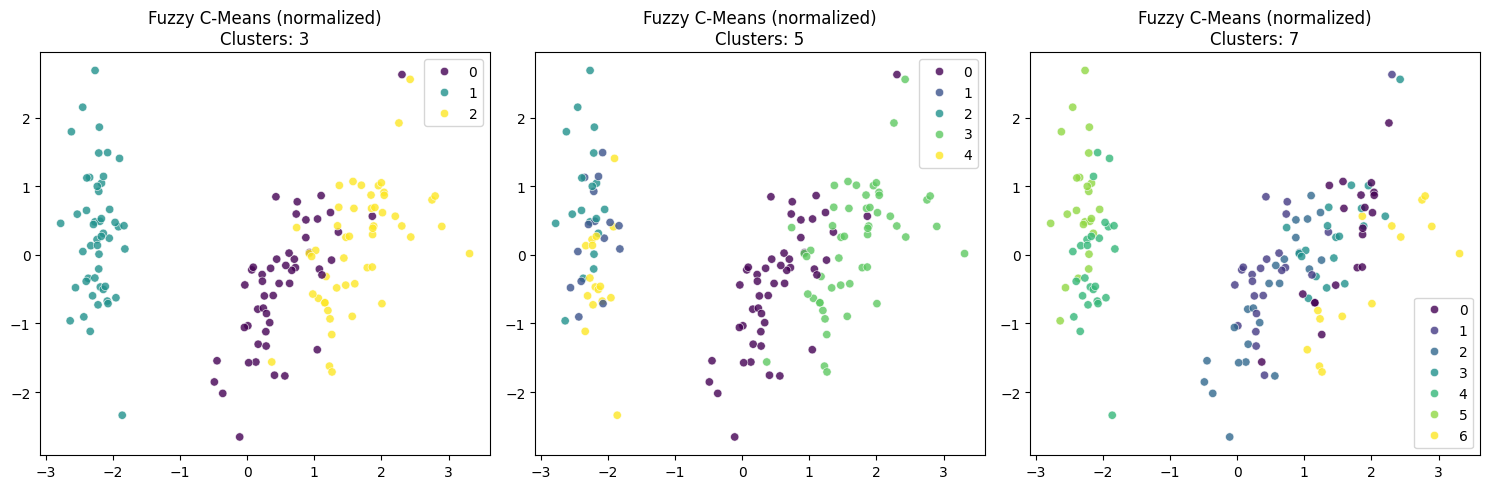

In [115]:
for method in methods:
    visualize_clusters(method, "Spectral Clustering", run_spectral, data_pca, data)
    visualize_clusters(method, "GMM", run_gmm, data_pca, data)
    visualize_clusters(method, "Fuzzy C-Means", run_fcm, data_pca, data)